# Manual ICA Review (Single Run)

Use this notebook to run the manual ICA workflow and contaminated-section rejection for a **specific** subject/session/run. All steps are adapted from `02_manual_ica_review.ipynb`, but without the multi-run queue so you can target a single recording directly.

In [67]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import yaml
import logging
from typing import Optional
from tqdm import tqdm
from pathlib import Path

notebook_dir = Path.cwd()
project_root = (notebook_dir / ".." ).resolve()
src_dir = project_root / "src"

if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

from utils.pathing import ensure_src_on_path, project_paths
ensure_src_on_path()
from utils.data_loader import EEGDataLoader
from utils.ica_plotting import plot_component_comprehensive

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


In [68]:
# Load project configuration
config_path = project_root / 'config' / 'analysis_config.yaml'
with config_path.open('r') as f:
    config = yaml.safe_load(f)

print("✅ Configuration loaded")
print(f"Subjects available: {config['subjects']['selected']}")

data_loader = EEGDataLoader(config_path=str(config_path))

2025-11-16 22:26:38,906 - INFO - EEGDataLoader initialized
  Project root: /Users/leeyelim/Documents/EEG
  Config: /Users/leeyelim/Documents/EEG/config/analysis_config.yaml
  Raw dir: /Users/leeyelim/Documents/EEG/ds002680 (exists=True)
  Preprocessed dir: /Users/leeyelim/Documents/EEG/data/preprocessed (exists=True)
  Derivatives dir: /Users/leeyelim/Documents/EEG/data/derivatives (exists=True)


✅ Configuration loaded
Subjects available: ['sub-015', 'sub-006', 'sub-010', 'sub-012', 'sub-007', 'sub-003', 'sub-002', 'sub-011', 'sub-004', 'sub-014']


## 2. Choose the Session to Process

### 2.1 Session-Level Merge Helper

In [69]:
from pathlib import Path
import re


def load_session_data(subject: str, session: str, stage: str = 'after_rereferencing'):
    """Load and (if needed) merge all runs for a session into a single Raw object.

    Returns
    -------
    merged_raw : mne.io.Raw
        Concatenated raw data for the whole session.
    merged_events : np.ndarray or None
        Events array with sample offsets adjusted across runs.
    event_id : dict or None
        Mapping of event labels to integer codes.
    merged_path : pathlib.Path
        Location where the merged FIF is stored (created/overwritten).
    run_summaries : List[dict]
        Metadata about each run merged into the session.
    """
    stage_root = project_root / 'data' / 'preprocessed' / stage / subject / session
    if not stage_root.exists():
        raise FileNotFoundError(f"Session directory not found: {stage_root}")

    pattern = f"{subject}_{session}_run-*_preprocessed_{stage}.fif"
    run_files = list(stage_root.glob(pattern))
    if len(run_files) == 0:
        raise FileNotFoundError(f"No runs matching '{pattern}' in {stage_root}")

    def _run_key(path: Path) -> int:
        match = re.search(r"run-(\d+)", path.name)
        return int(match.group(1)) if match else 0

    run_files = sorted(run_files, key=_run_key)

    raws = []
    run_summaries = []
    events_accumulator = []
    event_id = None
    sample_offset = 0

    for run_path in run_files:
        run_raw = mne.io.read_raw_fif(str(run_path), preload=True, verbose='ERROR')
        raws.append(run_raw)

        run_token_match = re.search(r"run-(\d+)", run_path.name)
        run_token = f"run-{run_token_match.group(1)}" if run_token_match else None

        run_summaries.append({
            'run': run_token,
            'path': str(run_path),
            'channels': len(run_raw.ch_names),
            'duration_sec': run_raw.times[-1]
        })

        try:
            if run_token is not None:
                events_tuple = data_loader.load_events(subject=subject, session=session, run=run_token)
            else:
                events_tuple = data_loader.load_events(subject=subject, session=session)
        except Exception as exc:
            logger.warning(f"Could not load events for {run_path.name}: {exc}")
            events_tuple = None

        if events_tuple is not None:
            run_events, run_event_id = events_tuple
            if run_event_id:
                event_id = run_event_id
            if run_events is not None and len(run_events) > 0:
                run_events = run_events.copy()
                run_events[:, 0] += sample_offset
                events_accumulator.append(run_events)

        sample_offset += run_raw.n_times

    merged_raw = mne.concatenate_raws(raws, preload=True, verbose=False)
    merged_filename = f"{subject}_{session}_preprocessed_{stage}_merged.fif"
    merged_path = stage_root / merged_filename
    merged_raw.save(str(merged_path), overwrite=True, verbose=False)

    merged_events = None
    if events_accumulator:
        merged_events = np.vstack(events_accumulator)
        order = np.argsort(merged_events[:, 0])
        merged_events = merged_events[order]

    return merged_raw, merged_events, event_id, merged_path, run_summaries


In [70]:
# Edit these variables to target a specific subject/session
TARGET_SUBJECT = 'sub-003'
TARGET_SESSION = 'ses-01'

session_root = project_root / 'data' / 'preprocessed' / 'after_rereferencing' / TARGET_SUBJECT
if not session_root.exists():
    raise FileNotFoundError(f"No preprocessed sessions found for {TARGET_SUBJECT} at {session_root}")

available_sessions = sorted(p.name for p in session_root.iterdir() if p.is_dir() and p.name.startswith('ses-'))  # pyright: ignore[reportUnreachable]
print(f"Available sessions for {TARGET_SUBJECT}: {available_sessions}")
if TARGET_SESSION not in available_sessions:
    raise ValueError(f"TARGET_SESSION '{TARGET_SESSION}' not in available sessions: {available_sessions}")

Available sessions for sub-003: ['ses-01', 'ses-02']


In [71]:
# Load or create the merged session file
preprocessing_stage = 'after_rereferencing'

raw, session_events, session_event_id, merged_path, run_summaries = load_session_data(
    TARGET_SUBJECT,
    TARGET_SESSION,
    stage=preprocessing_stage
)

print(f"🔄 Loaded session: {TARGET_SUBJECT} {TARGET_SESSION}")
print(f"📄 Merged file: {merged_path}")
print(f"📈 Channels: {len(raw.ch_names)} | Duration: {raw.times[-1]:.1f}s")

run_summary_df = pd.DataFrame(run_summaries)
display(run_summary_df)

current_session_label = f"{TARGET_SUBJECT}_{TARGET_SESSION}"
current_session_label

2025-11-16 22:26:39,083 - INFO - Loading EEG for sub-003: ses-01 run-1 → /Users/leeyelim/Documents/EEG/ds002680/sub-003/ses-01/eeg/sub-003_ses-01_task-gonogo_run-1_eeg.set
/Users/leeyelim/Documents/EEG/src/utils/data_loader.py:142: RuntimeWarning: Unknown types found, setting as type EEG:
nan: ['C3', 'C4', 'CB1', 'CB1"', 'CB2', 'CB2"', 'F3', 'F4', 'F7', 'F8', 'FP1', 'FP2', 'FZ', 'I', 'O1', "O1'", 'O2', "O2'", 'OZ', 'P3', 'P3"', 'P4', 'P4"', 'PZ', 'PZ"', 'T3', 'T4', 'T5', "T5'", 'T6', "T6'"]
  raw = mne.io.read_raw_eeglab(eeg_file, preload=True)
2025-11-16 22:26:39,250 - INFO - Loaded raw data for sub-003: 31 channels, 227.2s duration
2025-11-16 22:26:39,262 - INFO - DEBUG: Events file loaded: /Users/leeyelim/Documents/EEG/ds002680/sub-003/ses-01/eeg/sub-003_ses-01_task-gonogo_run-1_events.tsv
2025-11-16 22:26:39,263 - INFO - DEBUG: Events DataFrame shape: (200, 7)
2025-11-16 22:26:39,263 - INFO - DEBUG: Events DataFrame columns: ['onset', 'duration', 'sample', 'trial_type', 'response_t

🔄 Loaded session: sub-003 ses-01
📄 Merged file: /Users/leeyelim/Documents/EEG/data/preprocessed/after_rereferencing/sub-003/ses-01/sub-003_ses-01_preprocessed_after_rereferencing_merged.fif
📈 Channels: 31 | Duration: 2737.6s


,run,path,channels,duration_sec
0,run-1,/Users/leeyelim/Documents/EEG/data/preprocesse...,31,227.239
1,run-2,/Users/leeyelim/Documents/EEG/data/preprocesse...,31,223.879
2,run-3,/Users/leeyelim/Documents/EEG/data/preprocesse...,31,209.319
3,run-4,/Users/leeyelim/Documents/EEG/data/preprocesse...,31,209.039
4,run-5,/Users/leeyelim/Documents/EEG/data/preprocesse...,31,206.839
5,run-6,/Users/leeyelim/Documents/EEG/data/preprocesse...,31,208.079
6,run-7,/Users/leeyelim/Documents/EEG/data/preprocesse...,31,209.879
7,run-8,/Users/leeyelim/Documents/EEG/data/preprocesse...,31,208.319
8,run-9,/Users/leeyelim/Documents/EEG/data/preprocesse...,31,207.079
9,run-10,/Users/leeyelim/Documents/EEG/data/preprocesse...,31,205.999


'sub-003_ses-01'

## 3. Prepare Data for ICA

### 3.1 Pre-ICA Contaminated Section Review


In [72]:
# Helper: annotate a short artifact on a single channel before ICA

def annotate_preica_channel_segment(channel_name, start_time, end_time, description=None):
    """Add a BAD annotation confined to a single channel on the raw (pre-ICA) data."""
    if 'raw' not in globals() or raw is None:
        print("⚠️ Raw dataset is not loaded. Run the session loading cell first.")
        return

    if channel_name not in raw.ch_names:
        print(f"⚠️ Channel '{channel_name}' not found in the current recording.")
        return

    try:
        start_time = float(start_time)
        end_time = float(end_time)
    except (TypeError, ValueError):
        print("⚠️ Start and end times must be numeric (seconds).")
        return

    if end_time <= start_time:
        print("⚠️ End time must be greater than start time.")
        return

    duration = end_time - start_time
    if description is None:
        description = f"BADPRE_{channel_name}"

    annotation = mne.Annotations(
        onset=[start_time],
        duration=[duration],
        description=[description],
        ch_names=[[channel_name]],
    )

    if raw.annotations is None:
        raw.set_annotations(annotation)
    else:
        raw.set_annotations(raw.annotations + annotation)

    print(f"✅ Added pre-ICA channel annotation: {channel_name} {start_time:.2f}s–{end_time:.2f}s")


def load_preica_annotations(path: Path) -> Optional[mne.Annotations]:
    """Load saved pre-ICA annotations from TSV-like file."""
    if not path.exists():
        return None

    onsets = []
    durations = []
    descriptions = []
    channel_lists = []

    with path.open('r') as f:
        header = next(f, None)
        for line in f:
            parts = line.rstrip('\n').split('\t')
            if len(parts) < 3:
                continue
            onset, duration, desc = parts[:3]
            channels = parts[3] if len(parts) > 3 else ''
            try:
                onset_val = float(onset)
                duration_val = float(duration)
            except ValueError:
                continue
            onsets.append(onset_val)
            durations.append(duration_val)
            descriptions.append(desc)
            if channels:
                channel_lists.append(channels.split(','))
            else:
                channel_lists.append(None)

    if not onsets:
        return None

    ann = mne.Annotations(
        onset=onsets,
        duration=durations,
        description=descriptions,
    )
    # attach channel-wise info if available
    if any(ch_list is not None for ch_list in channel_lists):
        # MNE expects list of lists even if None
        ch_names = []
        for ch_list in channel_lists:
            if ch_list is None:
                ch_names.append(None)
            else:
                ch_names.append(ch_list)
        ann.ch_names = ch_names
    return ann


In [73]:
%gui qt
%matplotlib qt

if raw is None:
    raise RuntimeError("⚠️ No raw data loaded. Run the session loading cell above.")

pre_ica_dir = project_root / 'data' / 'preprocessed' / 'after_ica' / TARGET_SUBJECT / TARGET_SESSION
pre_ica_dir.mkdir(parents=True, exist_ok=True)
pre_ica_annot_path = pre_ica_dir / f"{TARGET_SUBJECT}_{TARGET_SESSION}_pre_ica_annotations.txt"

if raw.annotations is None or len(raw.annotations) == 0:
    loaded_ann = load_preica_annotations(pre_ica_annot_path)
    if loaded_ann is not None:
        print(f"📂 Loaded {len(loaded_ann)} saved pre-ICA annotations from {pre_ica_annot_path.name}")
        raw.set_annotations(loaded_ann)
else:
    print(f"ℹ️ Using in-memory annotations ({len(raw.annotations)} entries) prior to review.")

print("🧹 Inspecting pre-ICA data. Use the GUI to mark gross artifacts.")
print("   - Drag to annotate time ranges across all channels.")
print("   - For single-channel glitches, call annotate_preica_channel_segment(channel, start_s, end_s).")
print("   - Close the window when finished to continue.")

raw.plot(
    n_channels=min(40, len(raw.ch_names)),
    duration=15.0,
    scalings='auto',
    title='Pre-ICA Data – Mark Bad Sections',
    block=True
)

print("✅ Pre-ICA annotation step complete.")


ℹ️ Using in-memory annotations (2042 entries) prior to review.
🧹 Inspecting pre-ICA data. Use the GUI to mark gross artifacts.
   - Drag to annotate time ranges across all channels.
   - For single-channel glitches, call annotate_preica_channel_segment(channel, start_s, end_s).
   - Close the window when finished to continue.
Channels marked as bad:
none
✅ Pre-ICA annotation step complete.


In [77]:
### 4B. Save Pre-ICA Annotations

if raw is None:
    raise RuntimeError("⚠️ Raw dataset not loaded; run the session loading cell first.")

pre_ica_dir = project_root / 'data' / 'preprocessed' / 'after_ica' / TARGET_SUBJECT / TARGET_SESSION
pre_ica_dir.mkdir(parents=True, exist_ok=True)

pre_ica_annot_path = pre_ica_dir / f"{TARGET_SUBJECT}_{TARGET_SESSION}_pre_ica_annotations.txt"

if raw.annotations is None or len(raw.annotations) == 0:
    print("ℹ️ No annotations found; nothing saved.")
else:
    # Save as tab-separated text with channel info when available
    with pre_ica_annot_path.open('w') as f:
        f.write("onset\tduration\tdescription\tchannels\n")
        for onset, duration, desc, ch_names in zip(
            raw.annotations.onset,
            raw.annotations.duration,
            raw.annotations.description,
            raw.annotations.ch_names if raw.annotations.ch_names is not None else [None] * len(raw.annotations)
        ):
            if ch_names:
                channel_list = ','.join(ch_names)
            else:
                channel_list = ''
            f.write(f"{onset:.6f}\t{duration:.6f}\t{desc}\t{channel_list}\n")

    print(f"💾 Saved pre-ICA annotations to {pre_ica_annot_path}")

    globals()['last_pre_ica_annotation_path'] = str(pre_ica_annot_path)



💾 Saved pre-ICA annotations to /Users/leeyelim/Documents/EEG/data/preprocessed/after_ica/sub-003/ses-01/sub-003_ses-01_pre_ica_annotations.txt


In [79]:
if raw is not None:
    print("\n🔄 Preparing data for ICA (1 Hz high-pass filter)...")
    raw_ica = raw.copy()

    bad_segment_count = 0
    bad_total_seconds = 0.0
    if raw.annotations is not None and len(raw.annotations):
        descriptions = np.array(raw.annotations.description).astype(str)
        bad_mask = np.char.startswith(descriptions, 'BAD')
        if np.any(bad_mask):
            bad_segment_count = int(bad_mask.sum())
            bad_total_seconds = float(raw.annotations.duration[bad_mask].sum())
            print(f"   ⏳ ICA will skip {bad_segment_count} annotated segments (~{bad_total_seconds:.1f}s)")

    raw_ica.load_data()
    raw_ica.filter(
        l_freq=1,
        h_freq=None,
        picks='eeg',
        method='iir',
        iir_params=dict(order=4, ftype='butter'),
        skip_by_annotation='edge',
        verbose=False,
    )

    print("✅ Data prepared for ICA")
else:
    print("⚠️ Skipping: No data loaded")


🔄 Preparing data for ICA (1 Hz high-pass filter)...
   ⏳ ICA will skip 12 annotated segments (~0.0s)
✅ Data prepared for ICA


## 4. Fit ICA

In [78]:
if raw is not None:
    print("\n🔄 Fitting ICA...")
    n_components = min(50, len(raw_ica.ch_names) - 1)
    ica = mne.preprocessing.ICA(
        n_components=n_components,
        method='fastica',
        random_state=50,
        max_iter=3000,
        verbose=False
    )
    ica.fit(
        raw_ica,
        picks='eeg',
        reject_by_annotation='omit',
        verbose=False,
    )
    print(f"✅ ICA completed with {n_components} components")
else:
    print("⚠️ Skipping: No data loaded")


🔄 Fitting ICA...
✅ ICA completed with 30 components


## 5. Interactive Component Browser

In [ ]:
if raw is not None:
    try:
        from ipywidgets import IntSlider, Button, VBox, HBox, HTML, Output
        from IPython.display import display, clear_output
        from pathlib import Path as _Path
        bad_components = []

        expected_label = f"{TARGET_SUBJECT}_{TARGET_SESSION}"
        current_label = globals().get('current_session_label')
        if current_label != expected_label:
            # Try to infer from loaded paths and set gracefully
            loaded_cleaned_path = globals().get('loaded_cleaned_path')
            merged_path_val = globals().get('merged_path')
            if (
                (loaded_cleaned_path and f"{TARGET_SUBJECT}/{TARGET_SESSION}" in str(loaded_cleaned_path))
                or (merged_path_val and f"{TARGET_SUBJECT}_{TARGET_SESSION}" in str(merged_path_val))
            ):
                globals()['current_session_label'] = expected_label
            else:
                print(
                    f"⚠️ Session label mismatch (have {current_label or 'unknown'}; expected {expected_label})."
                    " Proceeding with current TARGET_* selection."
                )
                globals()['current_session_label'] = expected_label

        print("🎮 Interactive Component Browser with Categorization")
        print("=" * 60)
        print(f"📊 Reviewing all {n_components} ICA components")

        events = None
        try:
            if hasattr(raw, 'annotations') and len(raw.annotations) > 0:
                events, event_id = mne.events_from_annotations(raw)
                print(f"✓ Loaded {len(events)} events from raw annotations")
            else:
                events_tuple = data_loader.load_events()
                if events_tuple is not None:
                    events, event_id = events_tuple
                    print(f"✓ Loaded events from data loader: {len(events)}")
        except Exception as exc:
            print(f"⚠️ Could not load events: {exc}")
            events = None

        plot_output = Output()
        comparison_output = Output()
        status_label = HTML(value="<b>Status:</b> Select a component to begin")
        current_comp = {'idx': 0}

        roi_config = None
        if 'config' in globals():
            roi_config = globals()['config'].get('erp_analysis', {}).get('roi', {})

        def update_plot(comp_idx):
            with plot_output:
                clear_output(wait=True)
                try:
                    # Resolve ICA object and Raw for plotting
                    base_ica = (
                        globals().get('ica')
                        or globals().get('fitted_ica')
                        or globals().get('ica_model')
                        or globals().get('ica_obj')
                    )
                    if base_ica is None:
                        raise RuntimeError("No ICA object found (expected one of: ica/fitted_ica/ica_model/ica_obj). Please run the ICA fitting/loading cell.")

                    # Match Raw channels to the channels used to fit ICA to avoid info/data mismatch
                    base_raw = (
                        globals().get('raw_ica')
                        or globals().get('raw_for_ica')
                        or globals().get('raw_session')
                        or globals().get('raw_cleaned')
                        or globals().get('raw_after')
                        or globals().get('raw_before')
                        or globals().get('raw')
                    )
                    if base_raw is None:
                        raise RuntimeError("No Raw object found (expected one of: raw_ica/raw_for_ica/raw_session/raw_cleaned/raw_after/raw_before/raw)")
                    raw_for_plot = base_raw.copy().pick_channels(base_ica.ch_names)
                    fig = plot_component_comprehensive(
                        base_ica,
                        raw_for_plot,
                        comp_idx,
                        events=events,
                        data_loader=data_loader,
                        roi_config=roi_config,
                    )
                    plt.show()
                except Exception as exc:
                    print(f"Error plotting component {comp_idx}: {exc}")

        def compute_preview_window(comp_idx, duration=5.0, rms_window=0.5):
            sources = ica.get_sources(raw_ica)
            component_data = sources.get_data()[comp_idx, :]
            component_times = sources.times
            window_samples = max(1, int(rms_window * raw_ica.info['sfreq']))
            preview_samples = max(1, int(duration * raw_ica.info['sfreq']))

            max_power_idx = 0
            max_power = 0.0
            for i in range(len(component_data) - window_samples):
                window_data = component_data[i:i + window_samples]
                window_power = np.sqrt(np.mean(window_data ** 2))
                if window_power > max_power:
                    max_power = window_power
                    max_power_idx = i

            start_idx = max(0, max_power_idx - preview_samples // 2)
            end_idx = min(len(component_data), start_idx + preview_samples)
            start_idx = max(0, end_idx - preview_samples)

            start_time = float(component_times[start_idx])
            end_time = float(component_times[end_idx - 1]) if end_idx > start_idx else start_time + 1.0
            if end_time <= start_time:
                end_time = start_time + duration
            start_time = max(0.0, start_time)
            end_time = min(float(raw_ica.times[-1]), end_time)
            if end_time <= start_time:
                end_time = start_time + duration
            return start_time, end_time

        def show_channel_comparison(comp_idx):
            if raw is None:
                return

            with comparison_output:
                clear_output(wait=True)
                try:
                    print("🔍 Opening interactive comparison browser...")

                    raw_before = raw.copy().load_data()
                    raw_after = raw.copy().load_data()

                    ica_tmp = ica.copy()
                    ica_tmp.exclude = sorted(set(ica.exclude) | {comp_idx})
                    ica_tmp.apply(raw_after, verbose=False)

                    if raw.annotations is not None:
                        annotations_copy = raw.annotations.copy()
                        raw_before.set_annotations(annotations_copy)
                        raw_after.set_annotations(annotations_copy)

                    overlay_capable = False
                    try:
                        from mne.viz._figure import MNEBrowseFigure
                        overlay_capable = hasattr(MNEBrowseFigure, 'add_overlay')
                    except Exception:
                        overlay_capable = False

                    if overlay_capable:
                        browser = raw_before.plot(
                            n_channels=min(60, len(raw_before.ch_names)),
                            duration=15.0,
                            scalings='auto',
                            title=f'Original (light gray) vs Cleaned (green overlay) – IC {comp_idx}',
                            block=False,
                            color={'eeg': '#e0e0e0'},
                        )

                        if browser is not None and hasattr(browser, 'add_overlay'):
                            overlay_data = raw_after.get_data()
                            overlay_obj = browser.add_overlay(
                                overlay_data,
                                sfreq=raw_after.info['sfreq'],
                                ch_names=raw_after.ch_names,
                                color=(0.0, 0.8, 0.0),
                                alpha=0.9,
                                remove_dc=False,
                            )
                            try:
                                overlay_obj.set_linewidth(1.2)
                            except Exception:
                                pass
                            browser.settings(traces_mode='lines')
                            print("🖱️ Use the Raw browser window to scroll through time.")
                            print("   Gray traces: original; green overlay: after IC removal.")
                        else:
                            overlay_capable = False

                    if not overlay_capable:
                        print("ℹ️ Overlay mode not supported in this MNE version; opening paired-view browser instead.")
                        before_copy = raw_before.copy()
                        after_copy = raw_after.copy()
                        before_copy.rename_channels(lambda name: f"{name} (orig)")
                        after_copy.rename_channels(lambda name: f"{name} (clean)")
                        combined = before_copy.copy()
                        combined.add_channels([after_copy], force_update_info=True)
                        combined.plot(
                            n_channels=min(60, len(combined.ch_names)),
                            duration=15.0,
                            scalings='auto',
                            title=f'Original vs Cleaned (paired view) – IC {comp_idx}',
                            block=False,
                        )
                        print("🖱️ Scroll to view each pair of channels (orig vs clean).")
                except Exception as exc:
                    print(f'Comparison failed: {exc}')

        def update_status():
            comp_idx = current_comp['idx']
            category = component_categories.get(comp_idx, 'Uncategorized')
            cat_counts = {cat: 0 for cat in categories}
            uncategorized = n_components
            for cat in component_categories.values():
                if cat in cat_counts:
                    cat_counts[cat] += 1
                    uncategorized -= 1

            status_label.value = (
                f"<div style='padding:10px;background-color:#f0f0f0;border-radius:5px;'>"
                f"<b>Component {comp_idx}:</b> {category}<br><br>"
                f"🧠 Brain: {cat_counts['Brain']} | 💪 Muscle: {cat_counts['Muscle']} | "
                f"👁️ Eye: {cat_counts['Eye']} | ⚡ Line: {cat_counts['Line']} | "
                f"📡 Channel: {cat_counts['Channel']} | ❔ Other: {cat_counts['Other']} | "
                f"❓ Uncategorized: {uncategorized}</div>"
            )

        categories = ['Brain', 'Muscle', 'Eye', 'Line', 'Channel', 'Other']
        bad_categories = ['Muscle', 'Eye', 'Line', 'Channel', 'Other']
        component_categories = {}

        slider = IntSlider(min=0, max=n_components - 1, step=1, value=0, description='Component:', continuous_update=False, layout={'width': '600px'})

        def on_slider_change(change):
            current_comp['idx'] = change['new']
            comparison_output.clear_output()
            update_plot(change['new'])
            update_status()

        slider.observe(on_slider_change, names='value')

        buttons = []
        for category in categories:
            style = ''
            if category == 'Brain':
                style = 'success'
            elif category == 'Muscle':
                style = 'warning'
            elif category == 'Eye':
                style = 'info'
            elif category == 'Line':
                style = 'danger'

            button = Button(description=category, button_style=style, layout={'width': '100px'})

            def on_click(btn, cat=category):
                component_categories[current_comp['idx']] = cat
                update_status()
                print(f"✓ Component {current_comp['idx']} categorized as: {cat}")

            button.on_click(on_click)
            buttons.append(button)

        def reset_category(btn):
            comp_idx = current_comp['idx']
            if comp_idx in component_categories:
                del component_categories[comp_idx]
                update_status()
                print(f"✓ Category reset for component {comp_idx}")

        reset_button = Button(description='Reset', layout={'width': '100px'})
        reset_button.on_click(reset_category)

        def export_categories(btn):
            global bad_components
            by_category = {cat: [] for cat in categories}
            by_category['Uncategorized'] = []
            for idx in range(n_components):
                cat = component_categories.get(idx, 'Uncategorized')
                by_category[cat].append(idx)

            print("\n" + "=" * 60)
            print("📋 COMPONENT CATEGORIZATION SUMMARY")
            for cat, comps in by_category.items():
                if comps:
                    print(f"{cat}: {comps}")

            bad_components = sorted(idx for idx in range(n_components) if component_categories.get(idx) in bad_categories)
            print("\n💡 Components marked for removal:", bad_components)
            update_status()

        export_button = Button(description='Export Summary', button_style='primary', layout={'width': '150px'})
        export_button.on_click(export_categories)

        compare_button = Button(
            description='Compare All Channels (5s window)',
            button_style='info',
            icon='line-chart',
            layout={'width': '260px'}
        )

        def on_compare(btn):
            show_channel_comparison(current_comp['idx'])

        compare_button.on_click(on_compare)

        display(VBox([
            slider,
            HBox(buttons[:3]),
            HBox(buttons[3:] + [reset_button]),
            HBox([export_button, compare_button]),
            status_label,
            plot_output,
            comparison_output
        ]))

        update_plot(0)
        update_status()

    except ImportError as exc:
        print(f"⚠️ ipywidgets is required for the interactive browser: {exc}")
else:
    print("⚠️ Skipping: No data loaded")

🎮 Interactive Component Browser with Categorization
📊 Reviewing all 30 ICA components
Used Annotations descriptions: [np.str_('animal_distractor'), np.str_('animal_target'), np.str_('correct'), np.str_('difficult_distractor'), np.str_('difficult_target'), np.str_('easy_distractor'), np.str_('easy_target'), np.str_('incorrect'), np.str_('nonanimal_distractor'), np.str_('nonanimal_target')]
✓ Loaded 2018 events from raw annotations


## 6. Select Components to Remove

In [81]:
if raw is not None:
    if 'bad_components' not in globals() or bad_components is None:
        bad_components = []

    print("=" * 60)
    print("📋 COMPONENT SELECTION SUMMARY")
    print("=" * 60)

    if len(bad_components) == 0:
        print("\n⚠️  No components selected for removal. Use the interactive browser above to mark artifact components.")
    else:
        invalid = [c for c in bad_components if c < 0 or c >= n_components]
        if invalid:
            print(f"\n❌ Invalid component indices: {invalid}")
        else:
            ica.exclude = bad_components
            pct_removed = (len(bad_components) / n_components) * 100
            print(f"\n✅ Selected {len(bad_components)} components for removal: {sorted(bad_components)}")
            print(f"   ({pct_removed:.1f}% of total components)")
            if pct_removed > 50:
                print("   ⚠️  Removing >50% of components — check data quality")
            elif pct_removed > 30:
                print("   ⚠️  Removing >30% — ensure these are true artifacts")
            else:
                print("   ✓ Reasonable number of components to remove")
    print("=" * 60)
else:
    print("⚠️ Skipping: No data loaded")

📋 COMPONENT SELECTION SUMMARY

✅ Selected 4 components for removal: [0, 1, 2, 3]
   (13.3% of total components)
   ✓ Reasonable number of components to remove


## 7. Apply ICA and Save

In [82]:
if raw is not None and 'bad_components' in globals() and len(bad_components) > 0:
    print("\n🔄 Applying ICA...")
    raw_cleaned = raw.copy()
    ica.apply(raw_cleaned)
    print("✅ ICA applied")

    ica_dir = project_root / 'data' / 'preprocessed' / 'after_ica'
    subject_ica_dir = ica_dir / TARGET_SUBJECT / TARGET_SESSION
    subject_ica_dir.mkdir(parents=True, exist_ok=True)

    cleaned_filename = merged_path.name.replace('after_rereferencing_merged', 'ica_cleaned')
    cleaned_path = subject_ica_dir / cleaned_filename
    raw_cleaned.save(str(cleaned_path), overwrite=True, verbose=False)
    print(f"💾 Saved cleaned data: {cleaned_path}")

    ica_filename = cleaned_filename.replace('.fif', '_ica.fif')
    ica_path = subject_ica_dir / ica_filename
    ica.save(str(ica_path), overwrite=True)
    print(f"💾 Saved ICA object: {ica_path}")

else:
    print("⚠️ No components selected or data missing. Run the interactive browser and selection summary first.")


🔄 Applying ICA...
Applying ICA to Raw instance
    Transforming to ICA space (30 components)
    Zeroing out 4 ICA components
    Projecting back using 31 PCA components
✅ ICA applied


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_16517/2568843261.py:13: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_ica/sub-003/ses-01/sub-003_ses-01_preprocessed_ica_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_cleaned.save(str(cleaned_path), overwrite=True, verbose=False)


💾 Saved cleaned data: /Users/leeyelim/Documents/EEG/data/preprocessed/after_ica/sub-003/ses-01/sub-003_ses-01_preprocessed_ica_cleaned.fif
Overwriting existing file.
Writing ICA solution to /Users/leeyelim/Documents/EEG/data/preprocessed/after_ica/sub-003/ses-01/sub-003_ses-01_preprocessed_ica_cleaned_ica.fif...
💾 Saved ICA object: /Users/leeyelim/Documents/EEG/data/preprocessed/after_ica/sub-003/ses-01/sub-003_ses-01_preprocessed_ica_cleaned_ica.fif


In [83]:
### 8A. ERP SNR & SME Comparison (Before vs After ICA)

"""Compute ERP SNR (dB) and Standardized Measurement Error (µV) for each ROI."""

if raw is not None:
    snr_events = session_events
    if snr_events is None or len(snr_events) == 0:
        try:
            snr_events, snr_event_id = mne.events_from_annotations(raw)
        except Exception as exc:
            print(f"⚠️ Unable to derive events for SNR/SME computation: {exc}")
            snr_events = None

    if snr_events is None or len(snr_events) == 0:
        print("⚠️ No events available; skipping ERP quality metrics.")
    else:
        roi_cfg = config.get('erp_analysis', {}).get('roi', {})
        rois = {
            'Frontal ROI': roi_cfg.get('frontal', []),
            'Parietal ROI': roi_cfg.get('parietal', [])
        }

        def prepare_events_for_epochs(events):
            events_array = np.asarray(events)
            if events_array.size == 0:
                return None, 0

            if events_array.ndim != 2 or events_array.shape[1] != 3:
                print("⚠️ Unexpected events array shape for ERP quality metrics; skipping.")
                return None, 0

            if not np.all(np.diff(events_array[:, 0]) >= 0):
                events_array = events_array[np.argsort(events_array[:, 0], kind='stable')]

            unique_samples, unique_indices = np.unique(events_array[:, 0], return_index=True)
            duplicate_count = events_array.shape[0] - unique_samples.size
            if duplicate_count:
                events_array = events_array[np.sort(unique_indices)]

            events_array = events_array.astype(int, copy=True)
            return events_array, duplicate_count

        events_for_epochs, dropped_duplicates = prepare_events_for_epochs(snr_events)
        if events_for_epochs is None:
            print("⚠️ Events could not be prepared for ERP quality metrics; skipping.")
        else:
            if dropped_duplicates:
                print(f"⚠️ Dropping {dropped_duplicates} duplicate events for ERP quality metrics.")

        def compute_erp_quality_metrics(raw_obj, roi_label, roi_channels, events_array):
            VOLTS_TO_UV = 1e6

            if events_array is None:
                return np.nan, {}, np.nan

            picks = mne.pick_channels(raw_obj.ch_names, roi_channels)
            if len(picks) == 0:
                return np.nan, {}, np.nan

            epochs = mne.Epochs(
                raw_obj,
                events_array,
                event_id=None,
                tmin=-0.2,
                tmax=0.6,
                baseline=None,
                preload=True,
                event_repeated='drop',
                verbose=False
            )

            n_epochs = len(epochs)
            if n_epochs == 0:
                return np.nan, {}, np.nan

            data = epochs.get_data(picks=picks)  # (n_epochs, n_channels, n_times)
            times = epochs.times

            signal_window = (times >= 0) & (times <= 0.6)
            baseline_window = (times >= -0.2) & (times <= 0)
            if not np.any(signal_window) or not np.any(baseline_window):
                return np.nan, {}, np.nan

            erp = data.mean(axis=0)
            signal_power = np.var(erp[:, signal_window], axis=1)

            baseline_data = data[:, :, baseline_window]
            noise_power = np.var(baseline_data, axis=(0, 2))

            signal_data = data[:, :, signal_window]
            roi_trial_amplitudes = signal_data.mean(axis=(1, 2))
            ddof = 1 if n_epochs > 1 else 0
            sme_uv = float((np.std(roi_trial_amplitudes, ddof=ddof) / np.sqrt(max(n_epochs, 1))) * VOLTS_TO_UV)

            snr_channels = 10 * np.log10((signal_power + 1e-12) / (noise_power + 1e-12))
            channel_labels = [raw_obj.ch_names[p] for p in picks]

            return float(np.mean(snr_channels)), dict(zip(channel_labels, snr_channels)), sme_uv

        datasets = {'Before ICA': raw}
        if 'raw_cleaned' in globals():
            datasets['After ICA'] = raw_cleaned
        else:
            print("⚠️ ICA-cleaned data not available; using pre-ICA data for After ICA comparison.")
            datasets['After ICA'] = raw

        summary_rows = []

        for stage_label, dataset in datasets.items():
            for roi_label, roi_channels in rois.items():
                if not roi_channels:
                    print(f"⚠️ ROI definition missing for {roi_label}; skipping.")
                    continue

                snr_value, snr_per_channel, sme_value = compute_erp_quality_metrics(
                    dataset, roi_label, roi_channels, events_for_epochs
                )
                if np.isnan(snr_value) or np.isnan(sme_value):
                    print(f"⚠️ Could not compute ERP metrics for {roi_label} ({stage_label}).")
                    continue

                summary_rows.append({
                    'Stage': stage_label,
                    'ROI': roi_label,
                    'Channels': ", ".join(snr_per_channel.keys()),
                    'SNR (dB)': round(snr_value, 2),
                    'SME (µV)': round(sme_value, 3)
                })

        if summary_rows:
            summary_df = pd.DataFrame(summary_rows).sort_values(['ROI', 'Stage'])
            pivot_df = summary_df.pivot(index='ROI', columns='Stage', values=['SNR (dB)', 'SME (µV)'])

            delta_cols = {}
            if {'Before ICA', 'After ICA'}.issubset(pivot_df['SNR (dB)'].columns):
                delta_cols[('Δ Metrics', 'Δ SNR (dB)')] = (
                    pivot_df['SNR (dB)']['After ICA'] - pivot_df['SNR (dB)']['Before ICA']
                )
            if {'Before ICA', 'After ICA'}.issubset(pivot_df['SME (µV)'].columns):
                delta_cols[('Δ Metrics', 'Δ SME (µV)')] = (
                    pivot_df['SME (µV)']['After ICA'] - pivot_df['SME (µV)']['Before ICA']
                )

            if delta_cols:
                delta_df = pd.DataFrame(delta_cols)
                pivot_df = pd.concat([pivot_df, delta_df], axis=1)

            display(pivot_df)
        else:
            print("⚠️ ERP quality metrics computation did not produce any results.")
else:
    print("⚠️ Skipping ERP quality metrics: no data loaded.")


⚠️ Dropping 29 duplicate events for ERP quality metrics.


SNR (dB)             SME (µV)             Δ Metrics  \
                      After ICA Before ICA After ICA Before ICA Δ SNR (dB)   
ROI                                                                          
Frontal ROI              -17.20     -13.99     0.173      0.167      -3.21   
Parieto-Occipital ROI    -15.09     -14.83     0.152      0.166      -0.26   

                                  
                      Δ SME (µV)  
ROI                               
Frontal ROI                0.006  
Parieto-Occipital ROI     -0.014

## 8. Contaminated-Section Review Backend Setup

In [84]:
# Configure plotting backends for ICA review and contaminated-section rejection
from mne.viz import set_browser_backend
from IPython import get_ipython

print("🔧 Configuring plotting backends...")

ip = get_ipython()
COMPONENT_BROWSER_BACKEND = 'matplotlib'
ANNOTATION_BROWSER_BACKEND = 'qt'

if ip is not None:
    try:
        ip.run_line_magic('matplotlib', 'inline')
        print("✅ Component browser: matplotlib inline backend")
    except Exception as err:
        print(f"⚠️ Could not switch to inline backend: {type(err).__name__}: {err}")
else:
    print("⚠️ IPython shell not detected; defaulting to inline backend")

try:
    set_browser_backend('matplotlib')
except Exception as err:
    print(f"⚠️ set_browser_backend('matplotlib') failed: {err}")

print("   Contaminated-section reviewer:")
print("   Before launching raw_cleaned.plot(...), run %matplotlib qt (or tk) in a new cell")
print("   The notebook no longer forces the ipympl widget backend so Qt windows can open")

globals()['COMPONENT_BROWSER_BACKEND'] = COMPONENT_BROWSER_BACKEND
globals()['ANNOTATION_BROWSER_BACKEND'] = ANNOTATION_BROWSER_BACKEND

🔧 Configuring plotting backends...
✅ Component browser: matplotlib inline backend
   Contaminated-section reviewer:
   Before launching raw_cleaned.plot(...), run %matplotlib qt (or tk) in a new cell
   The notebook no longer forces the ipympl widget backend so Qt windows can open


## 9. Mark and Reject Contaminated Sections

After ICA removes artifact components, some contaminated time segments may still remain. This section allows you to:
- Visually inspect the cleaned data
- Mark time periods with remaining artifacts
- Reject contaminated sections before epoching

**Why this step is important:**
- ICA removes systematic artifacts (eye blinks, heartbeat, etc.)
- But transient artifacts (sudden movements, electrode pops) may remain
- Manual inspection ensures highest data quality
- Better to reject contaminated sections than include bad trials in ERP averaging


### 9.1 Load ICA-Cleaned Data

In [85]:
from pathlib import Path

print("=== Load ICA-Cleaned Data ===")

candidate_paths = []

# Prefer an in-memory cleaned session if available
if 'loaded_cleaned_path' in globals() and globals()['loaded_cleaned_path']:
    candidate_paths.append(Path(globals()['loaded_cleaned_path']))

# Expected file name based on the current selection
expected_dir = project_root / 'data' / 'preprocessed' / 'after_ica' / TARGET_SUBJECT / TARGET_SESSION
expected_name = merged_path.name.replace('after_rereferencing_merged', 'ica_cleaned')
candidate_paths.append(expected_dir / expected_name)

# Add any other ICA-cleaned FIF in the directory for this session
if expected_dir.exists():
    candidate_paths.extend(sorted(expected_dir.glob("*ica_cleaned.fif")))

cleaned_path = None
for path in candidate_paths:
    if path.exists():
        cleaned_path = path
        break

if cleaned_path is None:
    print("⚠️ No ICA-cleaned file found for the current session.")
    print("   Run the ICA application cell above before reviewing contaminated sections.")
    raise SystemExit

previous_path = globals().get('loaded_cleaned_path')
needs_reload = (
    'raw_cleaned' not in globals()
    or raw_cleaned is None
    or (previous_path and Path(previous_path) != cleaned_path)
)

if needs_reload:
    print(f"🔁 Loading {cleaned_path.name}")
    raw_cleaned = mne.io.read_raw_fif(str(cleaned_path), preload=True, verbose=False)
    globals()['raw_cleaned'] = raw_cleaned
else:
    raw_cleaned = globals()['raw_cleaned']
    print(f"✅ Using in-memory data from {cleaned_path.name}")

globals()['loaded_cleaned_path'] = str(cleaned_path)

if 'current_session_label' not in globals() or not current_session_label:
    current_session_label = f"{TARGET_SUBJECT}_{TARGET_SESSION}"
    globals()['current_session_label'] = current_session_label

print()
print("Next steps:")
print("1. In a new cell run: %matplotlib qt   (or %matplotlib tk if Qt is unavailable)")
print("2. Then run the viewer cell below to annotate contaminated sections.")
print("3. Close the window once finished and run Section 9B to save the annotations.")


=== Load ICA-Cleaned Data ===
✅ Using in-memory data from sub-003_ses-01_preprocessed_ica_cleaned.fif

Next steps:
1. In a new cell run: %matplotlib qt   (or %matplotlib tk if Qt is unavailable)
2. Then run the viewer cell below to annotate contaminated sections.
3. Close the window once finished and run Section 9B to save the annotations.


In [86]:
# Sanity-check: ensure the loaded ICA data matches the current target session
from pathlib import Path as _Path

loaded_path_value = globals().get('loaded_cleaned_path')
expected_label = f"{TARGET_SUBJECT}_{TARGET_SESSION}"
if not loaded_path_value:
    raise RuntimeError("⚠️ No ICA-cleaned file is loaded. Run the previous cell first.")

loaded_path_obj = _Path(loaded_path_value)
loaded_session = loaded_path_obj.parent.name if loaded_path_obj.parent else None
loaded_subject = loaded_path_obj.parent.parent.name if loaded_path_obj.parent and loaded_path_obj.parent.parent else None

if loaded_session != TARGET_SESSION or loaded_subject != TARGET_SUBJECT:
    print(f"⚠️ Loaded file {loaded_path_obj.name} belongs to {loaded_subject}/{loaded_session}; reloading {expected_label}.")
    target_dir = project_root / 'data' / 'preprocessed' / 'after_ica' / TARGET_SUBJECT / TARGET_SESSION
    expected_name = merged_path.name.replace('after_rereferencing_merged', 'ica_cleaned')
    search_paths = [target_dir / expected_name]
    if target_dir.exists():
        search_paths.extend(sorted(target_dir.glob("*ica_cleaned.fif")))

    cleaned_path = None
    for path in search_paths:
        if path.exists():
            cleaned_path = path
            break

    if cleaned_path is None:
        raise FileNotFoundError(f"No ICA-cleaned file found for {expected_label}.")

    annotated_path = cleaned_path.with_name(cleaned_path.name.replace('ica_cleaned', 'ica_cleaned_annotated'))
    base_to_load = annotated_path if annotated_path.exists() else cleaned_path
    print(f"🔁 Loading {base_to_load.name}")
    raw_cleaned = mne.io.read_raw_fif(str(base_to_load), preload=True, verbose=False)
    globals()['raw_cleaned'] = raw_cleaned
    globals()['loaded_cleaned_path'] = str(base_to_load)
    globals()['last_cleaned_path'] = str(cleaned_path)
    if annotated_path.exists():
        globals()['last_annotated_path'] = str(annotated_path)
else:
    print(f"✅ Loaded ICA file matches current target ({expected_label}).")



✅ Loaded ICA file matches current target (sub-003_ses-01).


### 9.2 Apply Average Reference
To ensure every time point sums to zero across all EEG channels before marking contaminated segments, re-reference the loaded `raw_cleaned` instance to the average reference.


In [91]:
if 'raw_cleaned' not in globals() or raw_cleaned is None:
    raise SystemExit("⚠️ No ICA-cleaned data in memory. Run the load cell above first.")

print("🎧 Applying average reference to `raw_cleaned` ...")
if raw_cleaned.info.get('custom_ref_applied', False):
    print("ℹ️ A custom reference has already been applied. Skipping re-reference step.")
else:
    raw_cleaned.set_eeg_reference('average', projection=False)
    print("✅ Average reference applied. All channel samples now sum to ~0 at each time point.")

try:
    import numpy as np
    eeg_picks = mne.pick_types(raw_cleaned.info, eeg=True, exclude=[])
    if len(eeg_picks) > 0:
        data = raw_cleaned.get_data(picks=eeg_picks)
        max_residual = float(np.abs(data.sum(axis=0)).max())
        print(f"   Residual channel-sum magnitude after re-ref: {max_residual:.3e}")
except Exception as err:
    print(f"⚠️ Skipped residual check: {err}")



🎧 Applying average reference to `raw_cleaned` ...
ℹ️ A custom reference has already been applied. Skipping re-reference step.
   Residual channel-sum magnitude after re-ref: 1.526e-10


In [93]:
def annotate_channel_segment(channel_name, start_time, end_time, description=None):
    """Annotate a time window as bad for a single channel only."""
    if 'raw_cleaned' not in globals() or raw_cleaned is None:
        print("⚠️ No ICA-cleaned dataset loaded. Run the load cell above first.")
        return

    if channel_name not in raw_cleaned.ch_names:
        print(f"⚠️ Channel '{channel_name}' not found in the current recording.")
        return

    try:
        start_time = float(start_time)
        end_time = float(end_time)
    except (TypeError, ValueError):
        print("⚠️ Start and end times must be numeric (seconds).")
        return

    if end_time <= start_time:
        print("⚠️ End time must be greater than start time.")
        return

    duration = end_time - start_time
    if description is None:
        description = f"BAD_{channel_name}"

    new_annotation = mne.Annotations(
        onset=[start_time],
        duration=[duration],
        description=[description],
        ch_names=[[channel_name]],
    )

    if raw_cleaned.annotations is None:
        raw_cleaned.set_annotations(new_annotation)
    else:
        raw_cleaned.set_annotations(raw_cleaned.annotations + new_annotation)

    print(f"✅ Added channel-specific BAD annotation: {channel_name} {start_time:.2f}s–{end_time:.2f}s")



### 9.3 Channel-Specific Annotation Helper

> 💡 **Channel-specific rejections:** Use `annotate_channel_segment('Fz', 12.5, 13.2)` to drop a short artifact from a single channel without affecting the others. The annotation is stored with the session and respected during later analyses.


### 9.4 Launch the Contaminated-Section GUI
Run this cell after loading and re-referencing the correct ICA-cleaned file to open the interactive browser for marking contaminated segments.


Channels marked as bad:
none


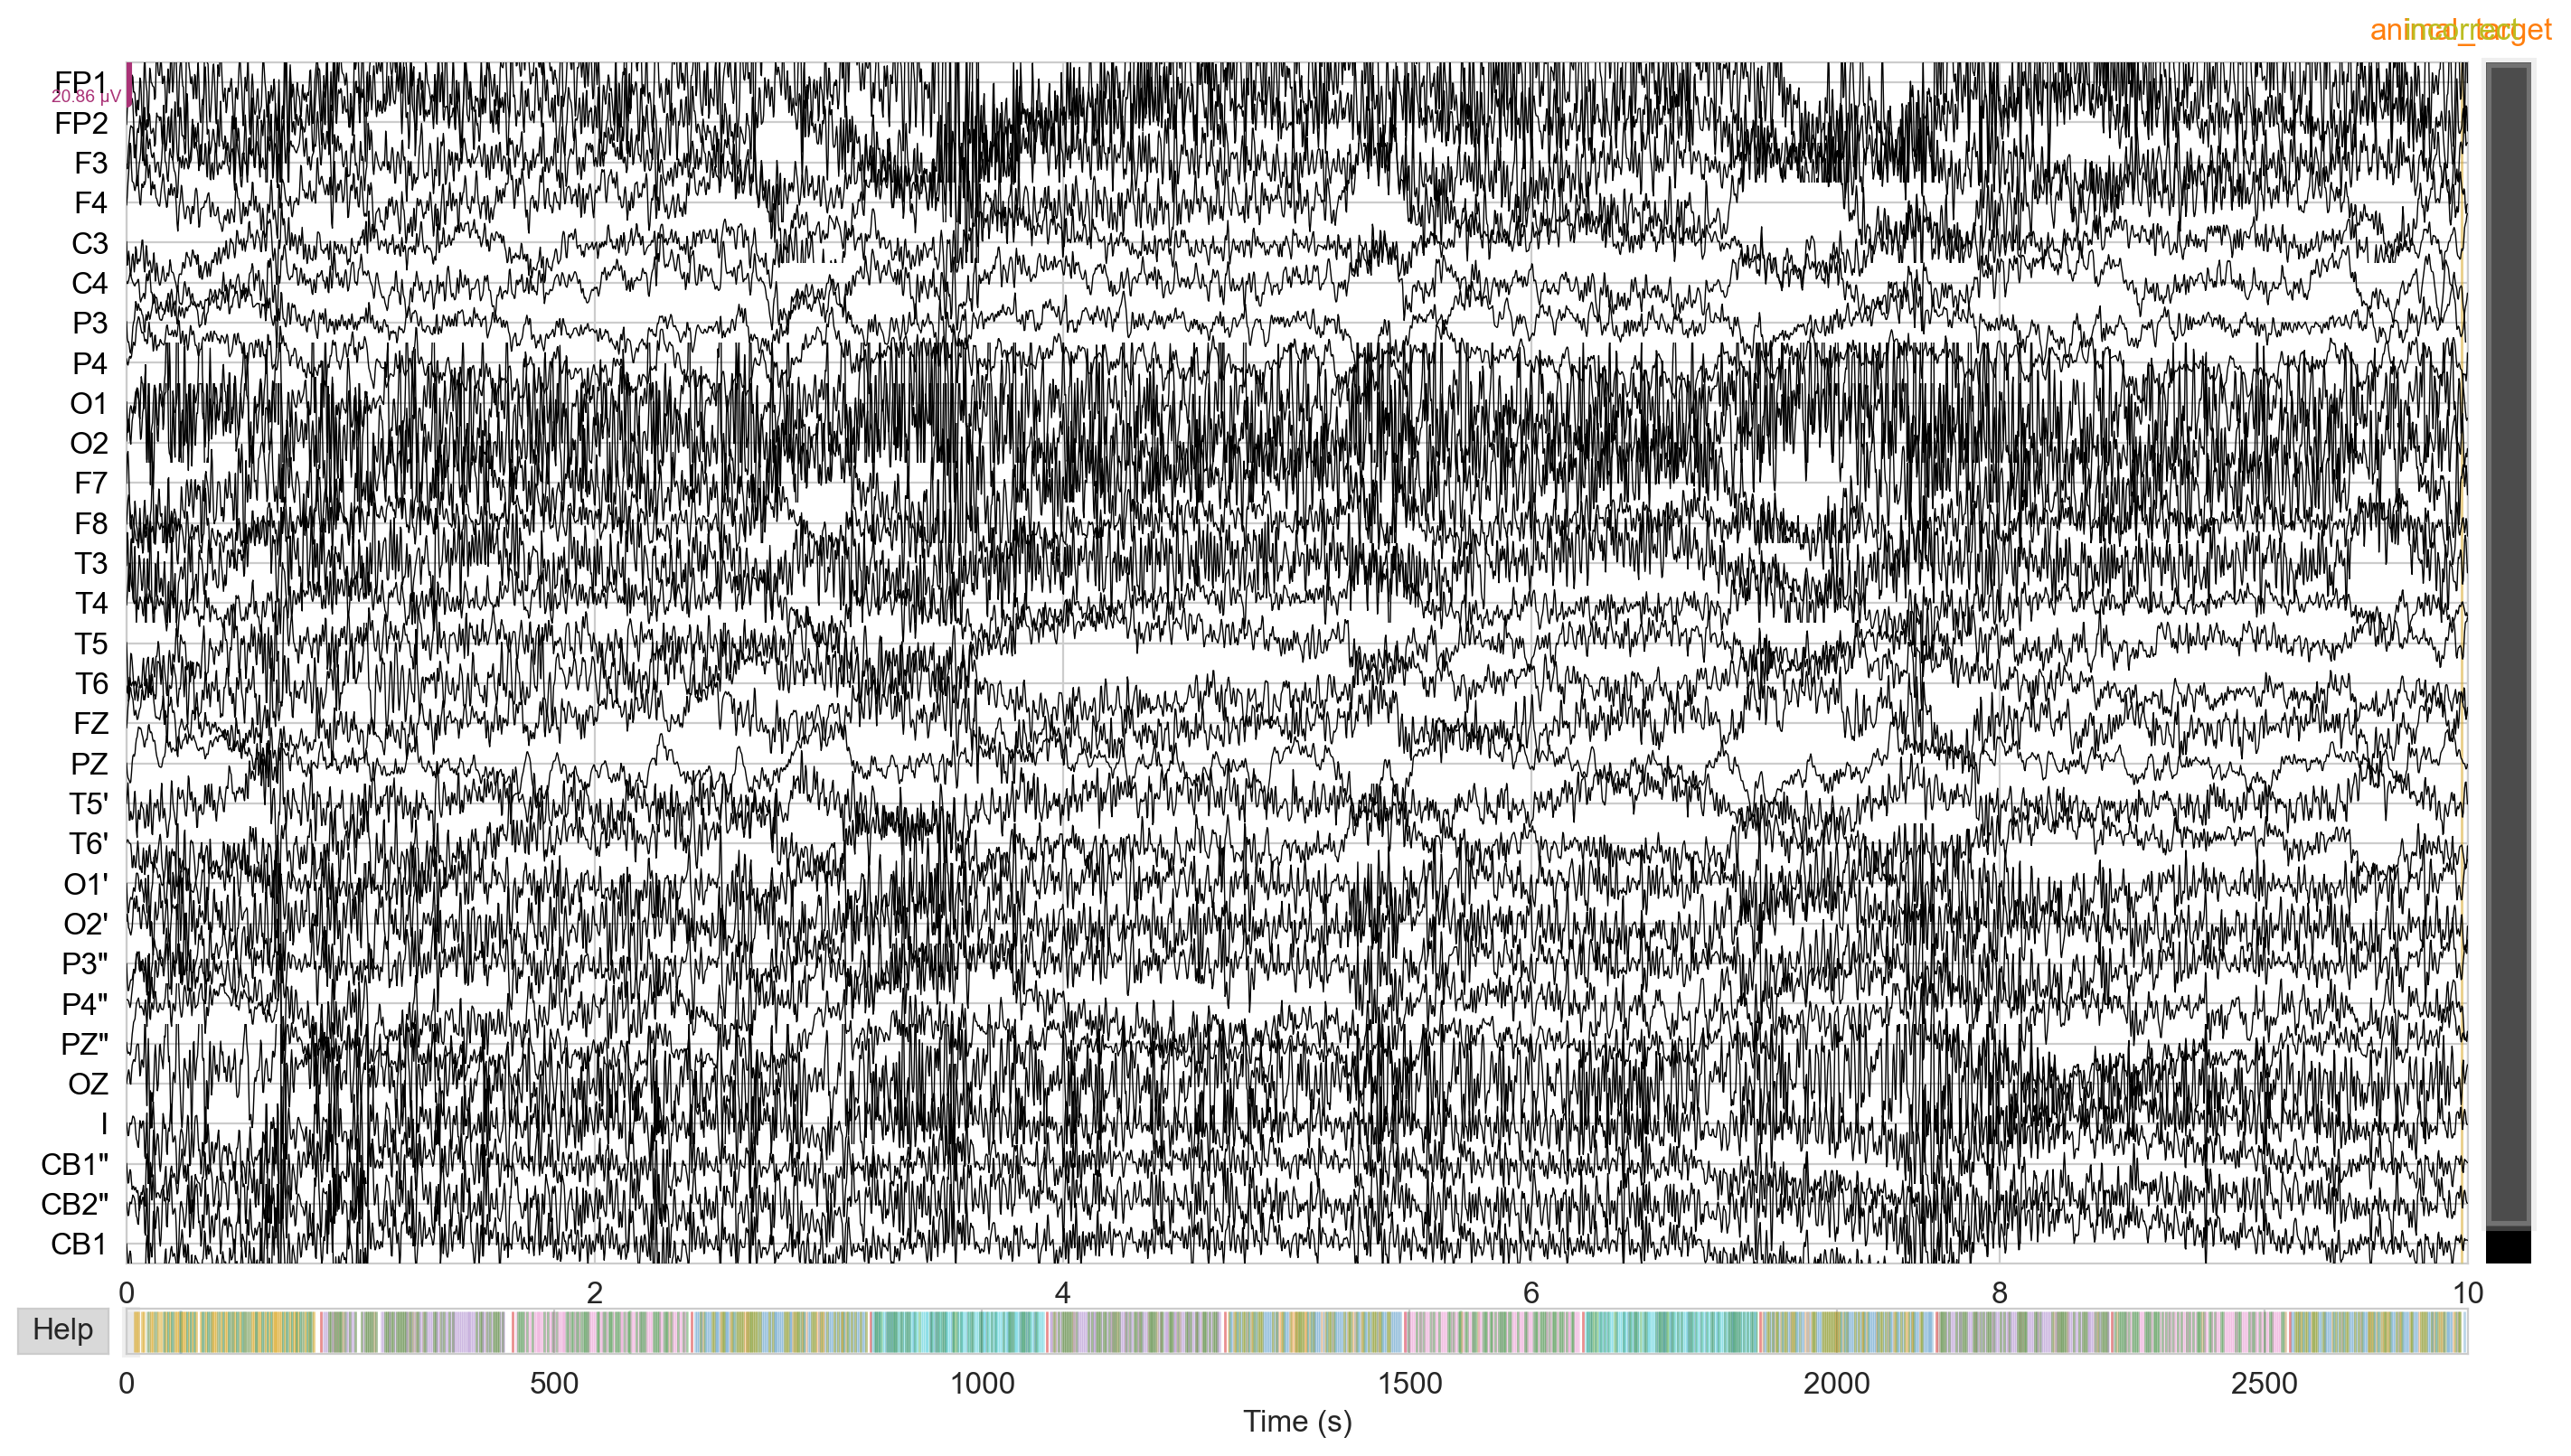

In [94]:
%gui qt
%matplotlib qt
raw_cleaned.plot(
    n_channels=30,
    duration=10.0,
    scalings='auto',
    title='ICA-Cleaned Data – Mark Bad Sections',
    block=True
)

### 9.2 Save Annotated Run

In [95]:
from pathlib import Path

if 'raw_cleaned' not in globals() or raw_cleaned is None:
    print("⚠️ No cleaned data in memory. Run Section 9A first.")
    raise SystemExit

cleaned_path = globals().get('loaded_cleaned_path')
if not cleaned_path or not Path(cleaned_path).exists():
    print("⚠️ Missing reference to the ICA-cleaned file. Re-run Section 9A before saving.")
    raise SystemExit

cleaned_path = Path(cleaned_path)
annotated_path = cleaned_path.with_name(cleaned_path.name.replace('ica_cleaned', 'ica_cleaned_annotated'))

globals()['last_cleaned_path'] = str(cleaned_path)
globals()['last_annotated_path'] = str(annotated_path)
globals()['last_session_label'] = current_session_label

print("📋 Review Marked Bad Segments")
print("=" * 60)
print(f"Session: {current_session_label}")

bad_annots = [annot for annot in raw_cleaned.annotations if 'bad' in annot['description'].lower()]

if bad_annots:
    print(f"✅ Found {len(bad_annots)} BAD segments marked:")
    print("-" * 60)
    total_duration = 0.0
    for idx, annot in enumerate(bad_annots, start=1):
        onset = annot['onset']
        duration = annot['duration']
        total_duration += duration
        print(f"  {idx}. Time: {onset:.2f}s – {onset + duration:.2f}s (Duration: {duration:.2f}s)")

    print("-" * 60)
    data_duration = raw_cleaned.times[-1]
    pct_rejected = (total_duration / data_duration) * 100
    print(f"📊 Total contaminated time: {total_duration:.2f} seconds ({pct_rejected:.1f}% of recording)")
    if pct_rejected > 20:
        print("   ⚠️  WARNING: >20% of data marked as bad – evaluate data quality")
    elif pct_rejected > 10:
        print("   ⚠️  Note: >10% of data marked as bad – higher than typical")
    else:
        print("   ✓ Reasonable amount of data rejected")

    print("💾 Saving cleaned data with bad segment annotations…")
    raw_cleaned.save(str(annotated_path), overwrite=True, verbose=False)
    print(f"✅ Saved annotated session: {annotated_path}")
else:
    print("✅ No BAD segments marked")
    print("   Saving an annotated copy to record that this session was reviewed")
    raw_cleaned.save(str(annotated_path), overwrite=True, verbose=False)
    print(f"✅ Saved reviewed session: {annotated_path}")

print("=" * 60)
print("🔁 Ready for next session: reset runtime variables.")

for name in ['current_session_label', 'raw_ica', 'raw_cleaned', 'ica', 'bad_components', 'loaded_cleaned_path']:
    globals().pop(name, None)

📋 Review Marked Bad Segments
Session: sub-003_ses-01
✅ Found 12 BAD segments marked:
------------------------------------------------------------
  1. Time: 227.24s – 227.24s (Duration: 0.00s)
  2. Time: 451.12s – 451.12s (Duration: 0.00s)
  3. Time: 660.44s – 660.44s (Duration: 0.00s)
  4. Time: 869.48s – 869.48s (Duration: 0.00s)
  5. Time: 1076.32s – 1076.32s (Duration: 0.00s)
  6. Time: 1284.40s – 1284.40s (Duration: 0.00s)
  7. Time: 1494.28s – 1494.28s (Duration: 0.00s)
  8. Time: 1702.60s – 1702.60s (Duration: 0.00s)
  9. Time: 1909.68s – 1909.68s (Duration: 0.00s)
  10. Time: 2115.68s – 2115.68s (Duration: 0.00s)
  11. Time: 2321.40s – 2321.40s (Duration: 0.00s)
  12. Time: 2528.84s – 2528.84s (Duration: 0.00s)
------------------------------------------------------------
📊 Total contaminated time: 0.00 seconds (0.0% of recording)
   ✓ Reasonable amount of data rejected
💾 Saving cleaned data with bad segment annotations…


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_16517/1509789375.py:47: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_ica/sub-003/ses-01/sub-003_ses-01_preprocessed_ica_cleaned_annotated.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_cleaned.save(str(annotated_path), overwrite=True, verbose=False)


✅ Saved annotated session: /Users/leeyelim/Documents/EEG/data/preprocessed/after_ica/sub-003/ses-01/sub-003_ses-01_preprocessed_ica_cleaned_annotated.fif
🔁 Ready for next session: reset runtime variables.


### 9.3 SNR Impact of Contaminated Section Rejection


In [96]:
from pathlib import Path

print("=== Comparing ERP SNR & SME Before vs After Contaminated Section Rejection ===")

if 'last_cleaned_path' not in globals() or 'last_annotated_path' not in globals():
    print("⚠️ Missing cleaned/annotated paths. Run Section 9B first.")
    raise SystemExit

cleaned_path = Path(last_cleaned_path)
annotated_path = Path(last_annotated_path)

if not cleaned_path.exists() or not annotated_path.exists():
    print("⚠️ Cleaned or annotated file not found. Ensure Section 9B completed successfully.")
    raise SystemExit

raw_before = mne.io.read_raw_fif(str(cleaned_path), preload=True, verbose=False)
raw_after = mne.io.read_raw_fif(str(annotated_path), preload=True, verbose=False)

snr_events = session_events
if snr_events is None or len(snr_events) == 0:
    try:
        snr_events, _ = mne.events_from_annotations(raw_before)
    except Exception as exc:
        print(f"⚠️ Unable to derive events for ERP quality comparison: {exc}")
        snr_events = None

if snr_events is None or len(snr_events) == 0:
    print("⚠️ No events available; skipping ERP quality comparison.")
    raise SystemExit

snr_events = np.asarray(snr_events)
if snr_events.ndim != 2 or snr_events.shape[1] != 3:
    print("⚠️ Unexpected event array shape; aborting ERP quality comparison.")
    raise SystemExit

snr_events = snr_events[np.argsort(snr_events[:, 0], kind='stable')]
unique_samples, unique_indices = np.unique(snr_events[:, 0], return_index=True)
if unique_indices.size != snr_events.shape[0]:
    duplicate_count = snr_events.shape[0] - unique_indices.size
    print(f"⚠️ Dropping {duplicate_count} duplicate events for ERP quality comparison.")
    snr_events = snr_events[np.sort(unique_indices)]

roi_cfg = config.get('erp_analysis', {}).get('roi', {})
rois = {
    'Frontal ROI': roi_cfg.get('frontal', []),
    'Parietal ROI': roi_cfg.get('parietal', [])
}

VOLTS_TO_UV = 1e6


def compute_erp_quality_with_annotations(raw_obj, events, roi_channels):
    picks = mne.pick_channels(raw_obj.ch_names, roi_channels)
    if len(picks) == 0:
        return np.nan, {}, np.nan

    epochs = mne.Epochs(
        raw_obj,
        events,
        event_id=None,
        tmin=-0.2,
        tmax=0.6,
        baseline=None,
        preload=True,
        reject_by_annotation=True,
        event_repeated='drop',
        verbose=False
    )

    n_epochs = len(epochs)
    if n_epochs == 0:
        return np.nan, {}, np.nan

    data = epochs.get_data(picks=picks)
    times = epochs.times

    signal_window = (times >= 0) & (times <= 0.6)
    baseline_window = (times >= -0.2) & (times <= 0)

    if not np.any(signal_window) or not np.any(baseline_window):
        return np.nan, {}, np.nan

    erp = data.mean(axis=0)
    signal_power = np.var(erp[:, signal_window], axis=1)

    baseline_data = data[:, :, baseline_window]
    noise_power = np.var(baseline_data, axis=(0, 2))

    signal_data = data[:, :, signal_window]
    roi_trial_amplitudes = signal_data.mean(axis=(1, 2))
    ddof = 1 if n_epochs > 1 else 0
    sme_uv = float((np.std(roi_trial_amplitudes, ddof=ddof) / np.sqrt(max(n_epochs, 1))) * VOLTS_TO_UV)

    snr_channels = 10 * np.log10((signal_power + 1e-12) / (noise_power + 1e-12))
    channel_labels = [raw_obj.ch_names[p] for p in picks]

    return (
        float(np.mean(snr_channels)),
        dict(zip(channel_labels, snr_channels)),
        sme_uv,
    )

summary_rows = []

for stage_label, dataset in {
    'Before Rejection': raw_before,
    'After Rejection': raw_after
}.items():
    for roi_label, roi_channels in rois.items():
        if not roi_channels:
            print(f"⚠️ ROI definition missing for {roi_label}; skipping.")
            continue

        snr_value, snr_per_channel, sme_value = compute_erp_quality_with_annotations(
            dataset, snr_events, roi_channels
        )
        if np.isnan(snr_value) or np.isnan(sme_value):
            print(f"⚠️ Could not compute ERP metrics for {roi_label} ({stage_label}).")
            continue

        summary_rows.append({
            'Stage': stage_label,
            'ROI': roi_label,
            'Channels': ", ".join(snr_per_channel.keys()),
            'SNR (dB)': round(snr_value, 2),
            'SME (µV)': round(sme_value, 3)
        })

if summary_rows:
    erp_quality_df = pd.DataFrame(summary_rows).sort_values(['ROI', 'Stage'])
    pivot = erp_quality_df.pivot(index='ROI', columns='Stage', values=['SNR (dB)', 'SME (µV)'])

    delta_cols = {}
    if {'Before Rejection', 'After Rejection'}.issubset(pivot['SNR (dB)'].columns):
        delta_cols[('Δ Metrics', 'Δ SNR (dB)')] = (
            pivot['SNR (dB)']['After Rejection'] - pivot['SNR (dB)']['Before Rejection']
        )
    if {'Before Rejection', 'After Rejection'}.issubset(pivot['SME (µV)'].columns):
        delta_cols[('Δ Metrics', 'Δ SME (µV)')] = (
            pivot['SME (µV)']['After Rejection'] - pivot['SME (µV)']['Before Rejection']
        )

    if delta_cols:
        delta_df = pd.DataFrame(delta_cols)
        pivot = pd.concat([pivot, delta_df], axis=1)

    display(pivot)
else:
    print("⚠️ ERP quality comparison did not produce any results.")


=== Comparing ERP SNR & SME Before vs After Contaminated Section Rejection ===


/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_16517/2914721761.py:16: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_ica/sub-003/ses-01/sub-003_ses-01_preprocessed_ica_cleaned.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_before = mne.io.read_raw_fif(str(cleaned_path), preload=True, verbose=False)
/var/folders/q4/kz31_kt96vx6s6rkzmfmyy080000gn/T/ipykernel_16517/2914721761.py:17: RuntimeWarning: This filename (/Users/leeyelim/Documents/EEG/data/preprocessed/after_ica/sub-003/ses-01/sub-003_ses-01_preprocessed_ica_cleaned_annotated.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _i

⚠️ Dropping 29 duplicate events for ERP quality comparison.


SNR (dB)                         SME (µV)  \
                      After Rejection Before Rejection After Rejection   
ROI                                                                      
Frontal ROI                    -17.20           -17.20           0.173   
Parieto-Occipital ROI          -15.09           -15.09           0.152   

                                        Δ Metrics             
                      Before Rejection Δ SNR (dB) Δ SME (µV)  
ROI                                                           
Frontal ROI                      0.173        0.0        0.0  
Parieto-Occipital ROI            0.152        0.0        0.0

In [ ]:
# 10a. Sub-003 SME by condition with ROI-specific window override
import numpy as np
import pandas as pd
import mne
from pathlib import Path
from typing import Tuple, Optional

SUBJECT = 'sub-003'
pre_root = project_root / 'data' / 'preprocessed' / 'after_rereferencing' / SUBJECT
after_root = project_root / 'data' / 'preprocessed' / 'after_ica' / SUBJECT
raw_events_root = project_root / 'ds002680' / SUBJECT
RESULTS_DIR = project_root / 'results'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
VOLTS_TO_UV = 1e6

cfg = config.get('erp_analysis', {})
baseline = tuple(cfg.get('baseline', [-0.1, 0.0]))
post_window_default = tuple(cfg.get('post_window', [0.3, 0.5]))
roi_cfg = cfg.get('roi', {})
roi_map = {
    'Frontal ROI': [ch for ch in roi_cfg.get('frontal', [])],
    'Parietal ROI': [ch for ch in roi_cfg.get('parietal', [])],
}

fam = {'animal_target','nonanimal_target','easy_target','difficult_target'}
new = {'animal_distractor','nonanimal_distractor','easy_distractor','difficult_distractor'}
valid = fam | new


def _window_for_roi(roi_label: str) -> Tuple[float,float]:
    return (0.4, 0.5) if 'Parieto' in roi_label else post_window_default


def _load_run_events(session: str, run_token: str, sfreq: float) -> np.ndarray:
    f = raw_events_root/session/'eeg'/f"{SUBJECT}_{session}_task-gonogo_{run_token}_events.tsv"
    if not f.exists():
        return np.empty((0,3), dtype=int)
    df = pd.read_csv(f, sep='\t')
    df = df[df['value'].isin(valid)]
    if df.empty:
        return np.empty((0,3), dtype=int)
    samples = (df['onset'].values * sfreq).round().astype(int)
    codes = np.array([1 if v in fam else 2 for v in df['value']], dtype=int)
    return np.column_stack([samples, np.zeros(len(samples), dtype=int), codes])


def _merge_session(stage_root: Path, session: str, suffix: str) -> Optional[mne.io.Raw]:
    ses_dir = stage_root / session
    if not ses_dir.exists():
        return None
    if suffix == 'ica_cleaned':
        cand = sorted(ses_dir.glob(f"{SUBJECT}_{session}_preprocessed_ica*_cleaned.fif"))
        if cand:
            raw = mne.io.read_raw_fif(str(cand[0]), preload=True, verbose='ERROR'); raw.load_data(); return raw
    run_files = sorted(ses_dir.glob(f"{SUBJECT}_{session}_run-*_preprocessed_{suffix}.fif"))
    if not run_files:
        return None
    raws = [mne.io.read_raw_fif(str(p), preload=True, verbose='ERROR') for p in run_files]
    [r.load_data() for r in raws]
    return raws[0] if len(raws)==1 else mne.concatenate_raws(raws, preload=True, verbose=False)


def _build_session_events(session: str, sfreq: float) -> np.ndarray:
    ses_dir = pre_root / session
    run_files = sorted(ses_dir.glob(f"{SUBJECT}_{session}_run-*_preprocessed_after_rereferencing.fif"))
    if not run_files:
        return np.empty((0,3), dtype=int)
    evs, off = [], 0
    for p in run_files:
        raw_tmp = mne.io.read_raw_fif(str(p), preload=False, verbose='ERROR')
        run_tok = p.stem.split('run-')[-1].split('_')[0]
        e = _load_run_events(session, f"run-{run_tok}", raw_tmp.info['sfreq'])
        if e.size:
            e[:,0] += off
            evs.append(e)
        off += raw_tmp.n_times
    if not evs:
        return np.empty((0,3), dtype=int)
    e = np.vstack(evs)
    return e[np.argsort(e[:,0])]


def _pick_roi(raw: mne.io.Raw, roi_label: str):
    desired = roi_map.get(roi_label, [])
    present = [ch for ch in desired if ch in raw.ch_names]
    if present:
        return mne.pick_channels(raw.ch_names, present, ordered=True), present
    return np.array([], dtype=int), []


def _epochs(raw: mne.io.Raw, events: np.ndarray) -> Optional[mne.Epochs]:
    if events.size == 0:
        return None
    try:
        return mne.Epochs(raw, events, event_id={'familiar':1,'new':2}, tmin=-0.2, tmax=0.6,
                          baseline=baseline, preload=True, event_repeated='drop', verbose='ERROR')
    except Exception:
        return None


def _sme_condition(epochs: Optional[mne.Epochs], picks: np.ndarray, window: Tuple[float,float], condition: str) -> float:
    if epochs is None or len(picks)==0:
        return float('nan')
    try:
        sel = epochs[condition]
    except Exception:
        return float('nan')
    if len(sel)==0:
        return float('nan')
    t = sel.times
    post = (t >= window[0]) & (t <= window[1])
    if not np.any(post):
        return float('nan')
    X = sel.get_data()[:, picks, :].mean(axis=1)
    trial_vals = X[:, post].mean(axis=1)
    n = max(len(trial_vals), 1)
    ddof = 1 if n>1 else 0
    return float((np.std(trial_vals, ddof=ddof) / np.sqrt(n)) * VOLTS_TO_UV)

# sessions present
sessions = sorted([p.name for p in pre_root.iterdir() if p.is_dir() and p.name.startswith('ses-')]) if pre_root.exists() else []
rows = []
for ses in sessions:
    raw_b = _merge_session(pre_root, ses, 'after_rereferencing')
    raw_a = _merge_session(after_root, ses, 'ica_cleaned')
    if raw_b is None or raw_a is None:
        continue
    ev = _build_session_events(ses, raw_b.info['sfreq'])
    if ev.size == 0:
        continue
    ep_b = _epochs(raw_b, ev)
    ep_a = _epochs(raw_a, ev)
    for roi_label in roi_map:
        win = _window_for_roi(roi_label)
        pb, used_b = _pick_roi(raw_b, roi_label)
        pa, used_a = _pick_roi(raw_a, roi_label)
        if len(pb)==0 or len(pa)==0:
            continue
        rows.append({
            'subject': SUBJECT,
            'session': ses,
            'ROI': roi_label,
            'SME_familiar_before_uV': _sme_condition(ep_b, pb, win, 'familiar'),
            'SME_familiar_after_uV': _sme_condition(ep_a, pa, win, 'familiar'),
            'SME_new_before_uV': _sme_condition(ep_b, pb, win, 'new'),
            'SME_new_after_uV': _sme_condition(ep_a, pa, win, 'new'),
        })

out = pd.DataFrame(rows)
# Add delta columns
if not out.empty:
    if {'SME_familiar_before_uV','SME_familiar_after_uV'}.issubset(out.columns):
        out['Delta_SME_familiar_uV'] = out['SME_familiar_after_uV'] - out['SME_familiar_before_uV']
    if {'SME_new_before_uV','SME_new_after_uV'}.issubset(out.columns):
        out['Delta_SME_new_uV'] = out['SME_new_after_uV'] - out['SME_new_before_uV']

out_file = RESULTS_DIR / 'group_erp_sme_by_condition_sub-003.csv'
out.to_csv(out_file, index=False)
print(f"Saved sub-003 condition-wise SME → {out_file} (rows={len(out)})")

# Aggregate across sessions (mean per ROI) to get a subject-level summary
if not out.empty:
    cols = [
        'SME_familiar_before_uV','SME_familiar_after_uV','Delta_SME_familiar_uV',
        'SME_new_before_uV','SME_new_after_uV','Delta_SME_new_uV'
    ]
    present = [c for c in cols if c in out.columns]
    summary = out.groupby('ROI')[present].mean().reset_index()
    sum_file = RESULTS_DIR / 'group_erp_sme_by_condition_sub-003_summary.csv'
    summary.to_csv(sum_file, index=False)
    print(f"Saved sub-003 condition-wise SME summary → {sum_file}")

out.head()


Saved sub-003 condition-wise SME → /Users/leeyelim/Documents/EEG/results/group_erp_sme_by_condition_sub-003.csv (rows=4)
Saved sub-003 condition-wise SME summary → /Users/leeyelim/Documents/EEG/results/group_erp_sme_by_condition_sub-003_summary.csv


,subject,session,ROI,SME_familiar_before_uV,SME_familiar_after_uV,SME_new_before_uV,SME_new_after_uV,Delta_SME_familiar_uV,Delta_SME_new_uV
0,sub-003,ses-01,Frontal ROI,0.450536,0.594675,0.476574,0.386113,0.144139,-0.090461
1,sub-003,ses-01,Parieto-Occipital ROI,0.375447,0.478713,0.380080,0.438791,0.103267,0.058711
2,sub-003,ses-02,Frontal ROI,0.465933,0.504863,0.484217,0.435230,0.038930,-0.048988
3,sub-003,ses-02,Parieto-Occipital ROI,0.391396,0.384181,0.382410,0.384010,-0.007215,0.001600
